# CONV NETS Testing

In [3]:
import numpy as np
import tensorflow as tf
import h5py
from utils import load_dataset
from utils import convert_to_one_hot
from utils import random_mini_batches
from layers.convolutional_layer import Conv
from layers.fullyconnected import FullyConnected
from layers.flatten import Flatten
from activations import relu, lkrelu, linear, sigmoid, cross_entropy
from neural_network import Network
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [4]:
(X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes) = load_dataset()

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1080
number of test examples = 120


## Example of a Picture

y = 4


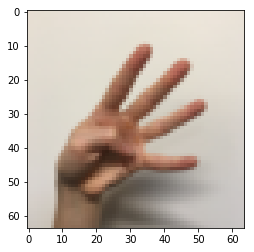

In [6]:
# Example of a picture
index = 17
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
plt.show()

In [7]:
layers = [
        Conv((5, 5, 3, 8), strides=1, activation=relu, filter_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (28*28 + 13*13*20)) ),
        Conv((3, 3, 8, 16), strides=1, activation=relu, filter_init=lambda shp:  np.random.normal(size=shp) *  np.sqrt(1.0 / (13*13*20 + 5*5*40)) ),
        Flatten((3, 3, 16)),
        FullyConnected((3*3*16, 20), activation=sigmoid, weight_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (5*5*40 + 100.))),
        FullyConnected((20, 6), activation=linear, weight_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (110.)))
    ]

In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    return X, Y

In [9]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [10]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None)

    return Z3

In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y) # Create Placeholders of the correct shape
    parameters = initialize_parameters()              # Initialize parameters
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [13]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

TypeError: range() integer end argument expected, got float.

## Test of the maxpool pass

In [7]:
dA_prev = pool_backward(A, cache_pool, mode="max")
print("size dA_prev: " + str(dA_prev.shape))

size dA_prev: (50, 64, 64, 8)


In [27]:
def forward_pass(X):
    W1_shape = [5,5,3,8]
    W2_shape = [3,3,8,16]
    W1 = he_initialization(W1_shape)
    W2 = he_initialization(W2_shape)
    b1 = np.zeros((1,1,1,8))
    b2 = np.zeros((1,1,1,16))
    
    cache = {}
    
    Z1, cache["Z1"] = conv_layer(X, W1, b1, {"pad": 2, "stride": 1})
    A1 = RELU_Layer(Z1)
    P1, cache["P1"] = pool_forward(A1, {"f": 8, "stride": 8})
    Z2, cache["Z2"] = conv_layer(P1, W2, b2, {"pad": 1, "stride": 1})
    A2 = RELU_Layer(Z2)
    P2, cache["P2"] = pool_forward(A2, {"f": 4, "stride": 4})
    m, h, w, c = P2.shape
    P2flat = np.zeros((m, h*w*c))
    
    for i in range(m):
        P2flat[i] = P2[i].flatten()
        
    W3 = np.random.randn(6, P2flat.shape[1]) * 0.01
    b1 = np.zeros((W3.shape[0], 1))
    
    Z3, cache["Z3"] = linear_forward(P2flat.T, W3,b1)
    ce = losses.CrossEntropy()
    Z3 = ce._softmax(Z3.T)

    return Z3, cache

In [ ]:
def backward_pass(X):
    

In [9]:
W1_shape = [5,5,3,8]
W2_shape = [3,3,8,16]
W1 = he_initialization(W1_shape)
W2 = he_initialization(W2_shape)
b1 = he_initialization((1,1,1,8))
b2 = he_initialization((1,1,1,16))